In [121]:
import pydantic
import cudf
import cugraph

from gnn_tracking.training.ml import MLModule
from pathlib import Path
from torch_cluster import radius_graph
import pandas as pd
import torch
from gnn_tracking.utils.timing import Timer


In [2]:

model_exchange_path = Path(
    "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/model_exchange"
)

In [3]:
from gnn_tracking.utils.loading import TrackingDataModule

dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/"
        ],
        # If you run into memory issues, reduce this
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/"
        ],
        stop=1
    ),
)

In [6]:
dm.setup(stage="fit")

[15:22:56] INFO: DataLoader will load 900 graphs (out of 900 available).
[15:22:56] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21999_s0.pt
[15:22:56] INFO: DataLoader will load 1 graphs (out of 1000 available).
[15:22:56] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29000_s0.pt


In [5]:
model = MLModule.load_from_checkpoint(model_exchange_path / "gc" / "gc-7dce6aff.ckpt")

[15:22:49] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction
[15:22:49] DEBUG: Getting class GraphConstructionHingeEmbeddingLoss from module gnn_tracking.metrics.losses


In [118]:
data = dm.datasets["train"][1]
out = model(data)
len(data.x)

64253

In [119]:
h = out["H"].detach()

In [27]:
def torch_to_cudf(tensor_dict):
    return cudf.DataFrame(
        {
            k: cudf.from_dlpack(torch.utils.dlpack.to_dlpack(v))
            for k, v in tensor_dict.items()
        }
    )

In [126]:


def collect_cluster_labels_gpu(h, radius=1):
    t = Timer()
    times = []
    h = h.detach()
    times.append(t())
    edge_index = radius_graph(h, r=radius)
    times.append(t())
    edge_df = torch_to_cudf({"source": edge_index[0], "destination": edge_index[1]})
    times.append(t())
    cug = cugraph.Graph()
    times.append(t())
    cug.from_cudf_edgelist(edge_df)
    times.append(t())
    cc_df = cugraph.connected_components(cug)
    times.append(t())
    return cc_df["labels"], times

In [127]:
collect_cluster_labels_gpu(h, radius=1)[1]

[0.00013352197129279375,
 0.9061640180298127,
 0.003115369996521622,
 1.6160018276423216e-05,
 0.03164340299554169,
 0.029617635998874903]

In [128]:
from gnn_tracking.postprocessing.dbscanscanner import dbscan

In [129]:
t = Timer()
labels = torch.Tensor(dbscan(h, eps=0.3)).to("cuda")
t()

0.8104133940069005

In [130]:
len(labels.unique())

3913

In [131]:
dm.datasets["val"][0]

Data(x=[59357, 14], edge_index=[2, 203759], y=[0], layer=[59357], particle_id=[59357], pt=[59357], reconstructable=[59357], sector=[59357])

In [132]:
cdf = torch_to_cudf({"c": labels, "id": data.particle_id})
df = pd.DataFrame({"c": labels.cpu().numpy(), "id": data.particle_id.cpu().numpy()})

In [133]:
len(df)

64253

In [137]:
from collections import Counter
import pandas as pd
import numpy as np


def tracking_metric_df_cuda(h_df: pd.DataFrame, predicted_count_thld=3) -> pd.DataFrame:
    """Label clusters as double majority/perfect/LHC.

    Args:
        h_df: Hit information dataframe
        predicted_count_thld: Number of hits a cluster must have to be considered a
            valid cluster

    Returns:
        cluster dataframe with columns such as "double_majority" etc.
    """
    # For each cluster, we determine the true PID that is associated with the most
    # hits in that cluster.
    # Here we make use of the fact that `df.value_counts` sorts by the count.
    # That means that if we group by the cluster and take the first line
    # for each of the counts, we have the most popular PID for each cluster.
    # The resulting dataframe now has both the most popular PID ("id" column) and the
    # number of times it appears ("0" column).
    # This strategy is a significantly (!) faster version than doing
    # c_id.groupby("c").agg(lambda x: x.mode()[0]) etc.
    pid_counts = h_df[["c", "id"]].value_counts().reset_index()

    # Compatibility issue with pandas 2.0 (2.0 uses 'count')
    _count_key = 0 if 0 in pid_counts.columns else "count"

    pid_counts_grouped = pid_counts.groupby("c")
    c_df = pid_counts_grouped.first().rename(
        {"id": "maj_pid", _count_key: "maj_hits"}, axis=1
    )
    # Number of hits per cluster
    c_df["cluster_size"] = pid_counts_grouped[_count_key].sum()
    # Assume that negative cluster labels mean that the cluster was labeled as
    # invalid
    predicted_counts = h_df["c"].value_counts()
    unique_predicted = predicted_counts.index
    # Cluster mask: all clusters that are not labeled as noise and have minimum number
    # of hits.
    c_df["valid_cluster"] = (unique_predicted >= 0) & (
        predicted_counts >= predicted_count_thld
    )

    # Properties associated to PID. This is pretty trivial, but since everything is
    # passed by hit, rather than by PID, we need to get rid of "duplicates"
    particle_properties = list(
        {"pt", "reconstructable", "eta"}.intersection(h_df.columns)
    )
    # Could to .first() for pt/reconstructable, but we want to average over eta
    pid_to_props = (
        h_df[["id", *particle_properties]].groupby("id")[particle_properties].mean()
    )
    c_df = c_df.merge(
        pid_to_props, left_on="maj_pid", right_index=True
    ).rename(columns={key: f"maj_{key}" for key in particle_properties})

    # For each PID: Number of hits (in any cluster)
    pid_to_count = h_df["id"].value_counts()
    # For each cluster: Take most popular PID of that cluster and get number of hits of
    # that PID (in any cluster)
    c_df["maj_pid_hits"] = c_df["maj_pid"].map(pid_to_count)

    # For each cluster: Fraction of hits that have the most popular PID
    c_df["maj_frac"] = (c_df["maj_hits"] / c_df["cluster_size"]).fillna(0)
    # For each cluster: Take the most popular PID of that cluster. What fraction of
    # the corresponding hits is in this cluster?
    c_df["maj_pid_frac"] = (c_df["maj_hits"] / c_df["maj_pid_hits"]).fillna(0)

    c_df["perfect_match"] = (
        (c_df["maj_pid_hits"] == c_df["maj_hits"])
        & (c_df["maj_frac"] > 0.99)
        & c_df["valid_cluster"]
    )
    c_df["double_majority"] = (
        (c_df["maj_pid_frac"] > 0.5) & (c_df["maj_frac"] > 0.5) & c_df["valid_cluster"]
    )
    c_df["lhc_match"] = (c_df["maj_frac"] > 0.75) & c_df["valid_cluster"]
    return c_df

In [138]:
t = Timer()
tracking_metric_df_cuda(cdf)
t()

0.022539139026775956

In [139]:
from gnn_tracking.metrics.cluster_metrics import tracking_metric_df
t = Timer()
tracking_metric_df(df)
t()

0.02637749002315104

In [141]:
h.shape

torch.Size([64253, 8])

In [144]:
def tensor_to_cudf(t):
    return torch_to_cudf({"i": t[:, i].squeeze() for i in range(t.shape[1])})

In [145]:
tensor_to_cudf(h)

RuntimeError: CUDF failure at: /opt/conda/conda-bld/work/cpp/src/interop/dlpack.cpp:156: from_dlpack of 1D DLTensor only for unit-stride data

In [147]:
h[:, 1].shape

torch.Size([64253])

In [227]:
t = Timer()
cuh = cudf.from_dlpack(torch.utils.dlpack.to_dlpack(h.T)).T
t()

1.5837182860122994

In [ ]:
_ = torch.utils.dlpack.to_dlpack(h)

In [174]:
cuh.shape

(64253, 8)

In [161]:
import cuml

In [162]:
from cuml.cluster import DBSCAN

In [182]:
cpid= cudf.from_dlpack(torch.utils.dlpack.to_dlpack(data.particle_id))

In [220]:
def get_dm(radius=1, ):
    dbscan = DBSCAN(eps=radius, min_samples=1)
    r = dbscan.fit(cuh, out_dtype='int64')
    labels = r.labels_
    tdf = cudf.DataFrame({"c": labels, "id": cpid})
    tmdf = tracking_metric_df_cuda(tdf)
    return tmdf["double_majority"].sum()


In [221]:
t = Timer()
results = []
eps = np.linspace(0.01, 1., 100)
for r in eps:
    results.append(get_dm(r))
t()

8.76749270799337

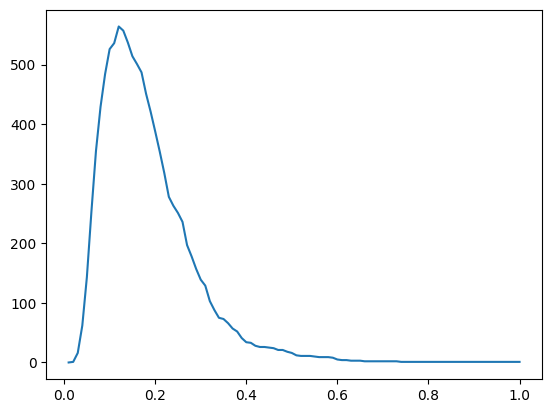

In [222]:
import matplotlib.pyplot as plt
plt.plot(eps, results)

In [ ]:
# import optuna
#
#
# def objective(trial):
#     eps = trial.suggest_float('eps', 0, 1)
#     return get_dm(radius=eps)
#
#
# study = optuna.create_study(direction='maximize')
# t = Timer()
# study.optimize(objective, n_trials=50)
# t()

In [169]:

len(r.labels_)

64253

In [151]:
h[:, 0].shape

torch.Size([64253])

In [152]:
h[:, 0].squeeze().shape

torch.Size([64253])